# Lab 4: Sparse Matrix Multiplication and Hardware Optimization

In this lab, we will explore opportunities for optimizing sparse matrix multiplication in hardware. We'll examine different optimization techniques like gating and skipping, and understand their impact on latency and energy efficiency. The lab will cover:

- Dense vs sparse matrix multiplication
- Optimization opportunities in sparse computations
- Hardware techniques for handling sparsity
- Energy and latency trade-offs of different techniques.

#### Question 1.0
Please answer the following questions. Otherwise, your submission will not be graded.

In [ ]:
from loaders import *

answer(
    question='1.0',
    subquestion=f'What is your name?',
    answer= 'Khushi Parikh',
    required_type=str,
)
answer(
    question='1.0',
    subquestion=f'What is your email address?',
    answer= 'khushi25@mit.edu',
    required_type=str,
)
answer(
    question='1.0',
    subquestion=f'What is your kerberos?',
    answer= 'khushi25',
    required_type=str,
)

# Part 1: Sparse Optimization Opportunities in Matrix Multiplication

Matrix multiplication is a fundamental operation in many computing applications, especially in machine learning and scientific computing. However, when matrices are sparse (containing many zeros), performing dense matrix multiplication can be inefficient, wasting both time and energy on operations involving zeros.

In this section, we will:
1. Review dense matrix multiplication as a baseline
2. Explore how sparsity creates opportunities for optimization
3. Analyze two key optimization techniques: gating and skipping
4. Calculate the potential savings in computation and energy

In all following questions, please assume that all tensors are independently
distributed (*e.g.*, if the density of A is 0.3 and the density of B is 0.4,
then you can assume that a multiplication in any tensor operation between A and
B has a $0.3 \times 0.4$ chance of being nonzero.)

In [ ]:
from loaders import *
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.sparse as ss
%run ./prelude.py --style=uncompressed --animation=movie

## Dense Matrix Multiplication

Before we discuss sparse matrix multiplication, we'll recap dense matrix multiplication. In the animation below, we'll see a simple animation of the matrix multiplication

$$Z_{m,n}=A_{m,k}B_{k,n}$$

In [ ]:
# Set default problem instance attributes (i.e., the shape of the tensors)
K = 4
M = 3
N = 3

A_MK = Tensor.fromRandom(name='A', rank_ids=['M', 'K'], shape=[M, K], density=1.0, color='blue')
B_KN = Tensor.fromRandom(name='B', rank_ids=['K', 'N'], shape=[K, N], density=1.0, color='green')
Z_MN = Tensor(name='Z', rank_ids=["M", "N"], shape=[M, N], color='red')

canvas = createCanvas(A_MK, B_KN, Z_MN)
cycle = 0

A_m = A_MK.getRoot()
B_k = B_KN.getRoot()
Z_m = Z_MN.getRoot()

# Traverse non-empty elements of top rank of `A`
for m, (Z_m_ref, A_k) in Z_m << A_m:
    # Traverse the K rank of `A`
    for k, A_val in A_k:
        # Obtain the matching fiber in `B`
        B_n = B_k.getPayload(k)
        # Traverse the bottom rank of `B`
        for n, (Z_mn_ref, B_val) in Z_m_ref << B_n:
            # Do the reduction
            Z_mn_ref += A_val * B_val
            # Animation bookkeeping
            canvas.addActivity((m,k), (k,n), (m, n), spacetime=(0,cycle))
            cycle += 1

displayCanvas(canvas)

## Sparse Optimization Opportunities

Now, we'll see what happens if the tensor $A$ is sparse with density 0.5. **Note which part of the code below is changed**.

In [ ]:
# Set default problem instance attributes (i.e., the shape of the tensors)
K = 4
M = 3
N = 3

########################################
### NOTE: density of A_MK is changed ###
########################################
A_MK = Tensor.fromRandom(name='A', rank_ids=['M', 'K'], shape=[M, K], density=0.5, color='blue')
B_KN = Tensor.fromRandom(name='B', rank_ids=['K', 'N'], shape=[K, N], density=1.0, color='green')
Z_MN = Tensor(name='Z', rank_ids=["M", "N"], shape=[M, N], color='red')

canvas = createCanvas(A_MK, B_KN, Z_MN)
cycle = 0

A_m = A_MK.getRoot()
B_k = B_KN.getRoot()
Z_m = Z_MN.getRoot()

# Traverse non-empty elements of top rank of `A`
for m, (Z_m_ref, A_k) in Z_m << A_m:
    # Traverse the K rank of `A`
    for k, A_val in A_k:
        # Obtain the matching fiber in `B`
        B_n = B_k.getPayload(k)
        # Traverse the bottom rank of `B`
        for n, (Z_mn_ref, B_val) in Z_m_ref << B_n:
            # Do the reduction
            Z_mn_ref += A_val * B_val
            # Animation bookkeeping
            canvas.addActivity((m,k), (k,n), (m, n), spacetime=(0,cycle))
            cycle += 1

displayCanvas(canvas)

### Question 1.1-1.4
Optimizing Ineffectual Operations

In [ ]:
answer(
    question='1.1',
    subquestion=f'What is the loop order of the dataflow illustrated above? Answer from outermost to innermost loop.',
    answer= 'MKN',
    required_type=('MKN', 'MNK', 'KMN', 'KNM', 'NKM', 'NMK')
)
answer(
    question='1.2',
    subquestion=f'If the density of the tensor A is 1, the density of tensor B is 1, and M=K=N=8, then how many effectual multiplies are there?',
    answer= 512,
    required_type=int
)
answer(
    question='1.3',
    subquestion=f'If the density of the tensor A is 0.5, the density of tensor B is 1, and M=K=N=8, then how many effectual (non-zero) multiplies are there?',
    answer= 256,
    required_type=int
)
answer(
    question='1.3',
    subquestion=f'If the density of the tensor A is 0.5, the density of tensor B is 1, and M=K=N=8, then how many ineffectual multiplies are there?',
    answer= 256,
    required_type=int
)
answer(
    question='1.4',
    subquestion=f'If the density of tensors A and B are both 0.5, and M=K=N=8, then how many effectual multiplies are there?',
    answer= 128,
    required_type=int
)

#### Question 1.5: 
There are two optimizations for ineffectual operations: gating and skipping. Gating explicitly lets the hardware staying idle on the ineffectual operation. Skipping explicitly fast forwards to next effectual operation. We provide you an example of cycle-behavior of each optimization in figure below for your understanding. Please specify the effect of each optimization in terms of latency and energy.
![explain](figures/GateSkipExample.png)

In [ ]:
# gating: fewer operations (read, compute), same number of processing steps
answer(
    question='1.5',
    subquestion=f'What might gating save in terms of latency, energy or both?',
    answer= 'energy',
    required_type=('latency', 'energy', 'both')
)

# skipping: fewer operations, fewer processing steps
answer(
    question='1.5',
    subquestion=f'What might skipping save in terms of latency, energy or both?',
    answer= 'both',
    required_type=('latency', 'energy', 'both')
)

## Tiled Sparse Matrix Multiplication

Suppose we want to tile the matrix multiplication in the $N$ rank into $N1$ and $N0$ and have the following loop nest.

```
for n1 in [0,N1)
 for m in [0,M)
  for k in [0,K)
   for n0 in [0,N0)
```

First, we tile the dimension $N$ into $N0$ and $N1$. This transforms tensor $B_{k,n}$ to $B_{k,n1,n0}$. The order of ranks of $B$ in memory is ```k -> n1 -> n0``` in $B_{k,n1,n0}$.

#### Question 1.6
Consider iterating through tensor $B_{k, n1, n0}$ in the order of the loop nest above.

In [ ]:

answer(
    question='1.6',
    subquestion=f'How would you describe the traversal of the $k$ rank in the order of the loop nest above if $B$ is compressed at the $k$ rank? (concordant, discordant)',
    answer= 'discordant',
    required_type=('concordant', 'discordant')
)

answer(
    question='1.6',
    subquestion=f'Would the above be more or less efficient than the traversal of the $k$ rank if it were compressed at the N0 rank? (more, less)',
    answer= 'less',
    required_type=('more', 'less')
)

answer(
    question='1.6',
    subquestion=f'Alternatively, would the first be more or less efficient than the traversal of the $k$ rank if it were compressed at the N1 rank? (more, less)',
    answer= 'less',
    required_type=('more', 'less')
)


You can observe how we leverage the above in the following images:

In [ ]:
K = 4
M = 3
N = 6
N0 = 3

# Note: B is now also sparse
B_KN = Tensor.fromRandom(name='B', rank_ids=['K', 'N'], shape=[K, N], density=0.75, color='green')

# NOTE: Split N rank in B
B_KN1N0 = B_KN.splitUniform(N0, depth=1)
displayTensor(B_KN)
displayTensor(B_KN1N0)

You can see there is a lot of inefficiency in storing weights that are 0. Because of this inefficiency, we'll rearrange the ranks of $B$ into $B_{n_1,k,n_0}$.

In [ ]:
B_N1KN0 = B_KN1N0.swapRanks()
displayTensor(B_N1KN0)

Now, we will show a matmul on the rearranged tensor $B$.

In [ ]:
Z_MN = Tensor(name='Z', rank_ids=["M", "N"], shape=[M, N], color='red')
Z_N1MN0 = Z_MN.splitUniform(N0, depth=1).swapRanks()

canvas = createCanvas(A_MK, B_N1KN0, Z_N1MN0)
cycle = 0

A_m = A_MK.getRoot()
B_n1 = B_N1KN0.getRoot()
Z_n1 = Z_N1MN0.getRoot()

# Traverse non-empty elements of top rank of `A`
for n1, (Z_n1_ref, B_n1k) in Z_n1 << B_n1:
    for m, (Z_n1m_ref, A_mk) in Z_n1_ref << A_m:
        for k, A_val in A_mk:
            B_n1kn0 = B_n1k.getPayload(k)
            for n0, (Z_n1mn_ref, B_val) in Z_n1m_ref << B_n1kn0:
                Z_n1mn_ref += A_val * B_val

                # Animation bookkeeping
                canvas.addActivity((m,k), (n1,k,n0), (n1, m, n0),
                                   spacetime=(0,cycle))
                cycle += 1

displayCanvas(canvas)

#### Question 1.7
Note that the number of non-zeroes in each $B_{n_1}$ (a tile with dimensions $k$ and $n_0$) are smaller than $K \cdot N_0$ because of sparsity. We may be able to use a smaller buffer to store the tiles if we compress them. 

*Please note: this video may exceed screen size limits.*

In [ ]:
answer(
    question='1.7',
    subquestion=f'Compression can increase the total amount of stored data when sparsity is low (i.e., density is high). However, the additional data stored will never exceed the savings from omitting zero values. (True/False)',
    answer= False,
    required_type=bool
)

# Part 2: Saving Energy with Gating

In this section, we will explore how gating can be used with sparse matrix multiplication. We will experiment with sparse architectures with gating using Sparseloop (an extension of Timeloop to support sparse architectures).

For this and part 3 (unless otherwise specified), we will look at a 2-level architecture with untiled mapping (see below).

![gating setup](figures/gating.png)

In the following cells, we show the problem, architecture, and mapping specifications.

In [ ]:
show_config('designs/problem.yaml')

In [ ]:
show_config('designs/arch.yaml')

In [ ]:
show_config('designs/untiled.map.yaml')

Below, we show the sparse optimization specification for Sparseloop. Note that both $A$ and $B$ in this scenario are **uncompressed**.

In [ ]:
show_config('designs/sparse_opts/buffer_gating.yaml')

We run Sparseloop without the sparse optimization first, then with the optimizations.

In [ ]:
 # The designs/top.yaml.jinja2 file includes designs/arch.yaml and designs/problem.yaml by default
result = run_timeloop_model(
    jinja_parse_data=dict(
        mapping='designs/untiled.map.yaml'
    )
)
stats = open('./output_dir/timeloop-model.stats.txt', 'r').read()
print(stats)

In [ ]:
 # The designs/top.yaml.jinja2 file includes designs/arch.yaml and designs/problem.yaml by default
result = run_timeloop_model(
    jinja_parse_data=dict(
        mapping='designs/untiled.map.yaml',
        sparse_optimizations='designs/sparse_opts/buffer_gating.yaml'
    )
)
stats = open('./output_dir/timeloop-model.stats.txt', 'r').read()
print(stats)

#### Question 2.1-2.2 
The *algorithmic-compute* stat is the number of computes in the workload without considering sparsity, while the *compute* stat considers sparsity. 
Accordingly, the *compute* stat (actual computes) describes the effectual computations, while the *algorithmic-compute* stat describes the sum of 
both effectual computations and ineffectual computations. Note that, when we gate computes, we may decrease total energy while increasing fJ/compute. This is
because we are decreasing the number of computes occurring.

Please fill the following:

In [ ]:
answer(
    question='2.1',
    subquestion=f'What is the total fJ/Algorithmic-Compute compute without gating? If algorithmic-compute numbers are not available, use the total fJ/compute.',
    answer= 7047.25,
    required_type=Number
)

answer(
    question='2.1',
    subquestion=f'What is the total fJ/Algorithmic-Compute with gating? If algorithmic-compute numbers are not available, use the total fJ/compute.',
    answer= 3972.35,
    required_type=Number
)

answer(
    question='2.1',
    subquestion='Which storage element was gated?',
    answer= 'Buffer',
    required_type=('Buffer', 'DRAM', 'MAC'),
)

answer(
    question='2.1',
    subquestion='Which compute element was gated?',
    answer= 'MAC',
    required_type=('Buffer', 'DRAM', 'MAC'),
)

answer(
    question='2.1',
    subquestion='Gating did NOT change the energy of which component?',
    answer= 'DRAM',
    required_type=('Buffer', 'DRAM', 'MAC'),
)

answer(
    question='2.1',
    subquestion=f'How does gating impact latency in this example?',
    answer= 'no impact',
    required_type=('increases', 'decreases', 'no impact')
)
answer(
    question='2.1',
    subquestion=f'How does gating impact energy in this example?',
    answer= 'decreases',
    required_type=('increases', 'decreases', 'no impact')
)

# Part 3: Increasing Throughput and Energy Efficiency with Skipping And Compression

In this section, we will analyze how skipping affects sparse matrix multiplication. For this part, we will compress both $A$ and $B$ and perform skipping.

![img](figures/skipping.png)

In [ ]:
result = run_timeloop_model(
    jinja_parse_data=dict(
        mapping='designs/untiled.map.yaml',
        sparse_optimizations='designs/sparse_opts/buffer_skipping.yaml'
    )
)
stats = open('./output_dir/timeloop-model.stats.txt', 'r').read()
print(stats)

#### Question 3.1-3.2
Interpreting Timeloop results

In [ ]:
answer(
    question='3.1',
    subquestion=f'What is the total fJ/compute without gating or skipping? If algorithmic-compute numbers are not available, use the total fJ/compute.',
    answer= 7047.25,
    required_type=Number
)
answer(
    question='3.1',
    subquestion=f'What is the total fJ/algorithmic-compute without gating or skipping? If algorithmic-compute numbers are not available, use the total fJ/compute.',
    answer= 7047.25,
    required_type=Number
)
answer(
    question='3.1',
    subquestion=f'What is the total fJ/compute with gating?',
    answer= 31778.79,
    required_type=Number
)
answer(
    question='3.1',
    subquestion=f'What is the total fJ/algorithmic-compute with gating?',
    answer= 3972.35,
    required_type=Number
)
answer(
    question='3.1',
    subquestion=f'What is the total fJ/compute with skipping and compression?',
    answer= 15358.43,
    required_type=Number
)
answer(
    question='3.1',
    subquestion=f'What is the total fJ/algorithmic-compute with skipping and compression?',
    answer= 1919.80,
    required_type=Number
)
answer(
    question='3.2',
    subquestion=f'How would increased sparsity (more zeros) impact total energy with gating and/or skipping?',
    answer= 'decrease',
    required_type=('increase', 'decrease', 'no impact')
)
answer(
    question='3.2',
    subquestion=f'How would increased sparsity (more zeros) impact the fJ/compute with skipping and compression?',
    answer= 'increase',
    required_type=('increase', 'decrease', 'no impact')
)
answer(
    question='3.2',
    subquestion=f'How would increased sparsity (more zeros) impact the fJ/algorithimic-compute with skipping and compression?',
    answer= 'decrease',
    required_type=('increase', 'decrease', 'no impact')
)

#### Question 3.3 
Below, we evaluate pJ/Algorithmic-Compute and pJ/Compute at different densities. Please complete the code below.

In [ ]:
density_A, density_B, pJ_algo, pJ_actual = [], [], [], []

for density_a in [0.25, 0.5, 0.75]:
    for density_b in [0.25, 0.5, 0.75]:
        # The designs/top.yaml.jinja2 file includes designs/arch.yaml and designs/problem.yaml by default
        run_timeloop_model(
            jinja_parse_data=dict(
                mapping='designs/untiled.map.yaml',
                sparse_optimizations='designs/sparse_opts/buffer_skipping.yaml',
                ########################
                #### YOUR CODE HERE ####
                ########################
                density_a=density_a, 
                density_b=density_b,
            )
        )
        stats = open('./output_dir/timeloop-model.stats.txt', 'r').read()
        fj_algo, fj_compute = None, None
        found_algo, found_compute = False, False
        for line in stats.split('\n'):
            if 'fJ/Algorithmic-Compute' in line:
                found_algo = True
            if 'fJ/Compute' in line:
                found_compute = True
            if found_algo and 'Total' in line and fj_algo is None:
                fj_algo = float(line.split('=')[-1].strip())
            if found_compute and 'Total' in line and fj_compute is None:
                fj_compute = float(line.split('=')[-1].strip())
        density_A.append(density_a)
        density_B.append(density_b)
        pJ_algo.append(fj_algo)
        pJ_actual.append(fj_compute)
        print(f'Density A: {density_a}, Density B: {density_b}, fJ/Algorithmic-Compute: {fj_algo}, fJ/Compute: {fj_compute}')
        
answer( # DO NOT CHANGE THIS BLOCK
    question='3.3',
    subquestion=f'What is your pJ/Algorithmic Compute? Do not change this answer block.',
    answer=pJ_algo,
    required_type=[Number] * len(pJ_algo)
)
answer( # DO NOT CHANGE THIS BLOCK
    question='3.3',
    subquestion=f'What is your pJ/Compute? Do not change this answer block.',
    answer=pJ_actual,
    required_type=[Number] * len(pJ_actual)
)

Now, we will look at the interaction between densities of different tensors and the pJ per algorithmic-compute and per compute.

In [ ]:
energy_per_compute_df = {
   'density_a': density_A,
   'density_b': density_B,
   'pJ_algorithmic': pJ_algo,
   'pJ_actual': pJ_actual,
}
energy_per_compute_df = pd.DataFrame(energy_per_compute_df)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
ax = sns.heatmap(energy_per_compute_df.pivot(index='density_a', columns='density_b', values='pJ_algorithmic'),
                 annot=True, ax=axes[0])
ax.set_title('fJ/Algorithmic-Compute')
ax.set_xlabel('B density')
ax.set_ylabel('A density')
ax = sns.heatmap(energy_per_compute_df.pivot(index='density_a', columns='density_b', values='pJ_actual'),
                 annot=True, ax=axes[1])
ax.set_title('fJ/Compute')
ax.set_xlabel('B density')
ax.set_ylabel('A density')
plt.show(fig)

# Part 4: The Effect of Sparsity on Compressed Tensor Buffer Space Usage

#### Question 4.1 
In the previous two sections we have focused on energy. In this section, we will see how different levels of sparsity affect buffer space usage when using compressed formats.

Keeping the density of B constant (density=1), sweep the density of A and fill the table below. We are only interested in the usage of `Buffer` by tensor $A$. The data storage refers to "max utilized data storage capacity". The format storage refers to the total sum of metadata and payload for rank 1 and 0. Note that Timeloop reports the metadata cost relative to each rank, while we want to determine the total sum of non-data storage used. (Hint: look for "max utilized data storage capacity" and "max utilized repr format storage capacity" in the stats for `Buffer` and tensor $A$). 

In [ ]:
DENSITIES_TO_RUN = [0.2, 0.4, 0.6, 0.8, 1]

# The designs/top.yaml.jinja2 file includes designs/arch.yaml and designs/problem.yaml by default
result = run_timeloop_model(
    jinja_parse_data=dict(
        mapping='designs/untiled.map.yaml',
        sparse_optimizations='designs/sparse_opts/buffer_compressed.yaml',
        density_a=1
    )
)

stats = open('./output_dir/timeloop-model.stats.txt', 'r').read()
print(stats)

4.1: What is the data storage used for each density?
	[13, 26, 39, 52, 64]
4.1: What is the format storage used for each density?
	[25, 41, 49, 65, 73]


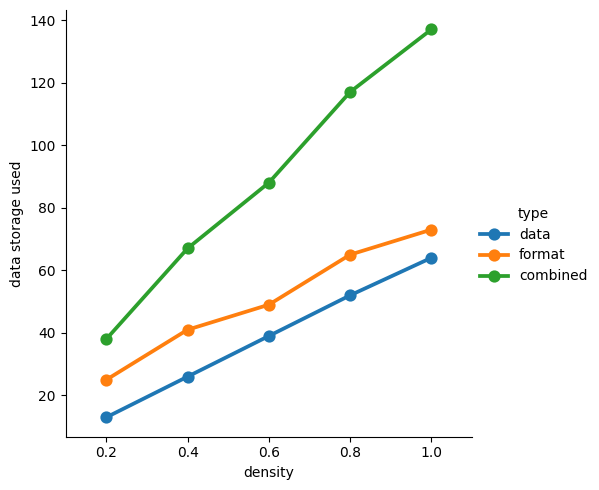

In [36]:

densities = DENSITIES_TO_RUN
########################
#### YOUR CODE HERE ####
########################
data_storage_used = [13, 26, 39, 52, 64] # FILL ME
format_storage_used = [25, 41, 49, 65, 73] # FILL ME

answer( # DO NOT CHANGE THIS BLOCK
    question='4.1',
    subquestion=f'What is the data storage used for each density?',
    answer=data_storage_used,
    required_type=[int] * len(data_storage_used)
)
answer( # DO NOT CHANGE THIS BLOCK
    question='4.1',
    subquestion=f'What is the format storage used for each density?',
    answer=format_storage_used,
    required_type=[int] * len(format_storage_used)
)

a_capacity_df = {
   'density': densities,
   'data': data_storage_used,
   'format': format_storage_used
}
a_capacity_df = pd.DataFrame(a_capacity_df)
a_capacity_df['combined'] = a_capacity_df['data'] + a_capacity_df['format']
a_capacity_df = a_capacity_df.melt('density', var_name='type', value_name='data storage used')
sns.catplot(x='density', y='data storage used', hue='type', data=a_capacity_df, kind='point')

#### Question 4.2 
What would be the space usage (in words) of an uncompressed representation of tensor $A$? Roughly, at what density interval would it be beneficial in terms of storage to keep $A$ in this compression format?

In [37]:
answer(
    question='4.2',
    subquestion=f'What would be the space usage (in words) of an uncompressed representation of tensor A?',
    answer= 64,
    required_type=int,
)
answer(
    question='4.2',
    subquestion=f'Below what density would it be beneficial in terms of storage to keep A in this compression format?',
    answer= 0.2,
    required_type=(0.2, 0.4, 0.6, 0.8, 1),
)

4.2: What would be the space usage (in words) of an uncompressed representation of tensor A?
	64
4.2: Below what density would it be beneficial in terms of storage to keep A in this compression format?
	0.2


# Part 5: Breaking Assumptions

For the previous sections, you were asked to assume that *all tensors are independently distributed*. While this statement tends to hold for DNNs, it is not generally true for sparse matrix multiplication. Here, we will explore how different density distributions can change the number of effectual operations and how different input densities affect the output. 

#### Question 5.1 
The Identity Matrix

In this section, both A and B are the identity matrix. 

In [38]:
M = K = N = 8

# Example 1: Identity Pattern
A = np.identity(K)
B = np.identity(K)

In [39]:
answer(
    question='5.1',
    subquestion=f'What is the density of matrix A?',
    answer= 0.125,
    required_type=float
)

answer(
    question='5.1',
    subquestion=f'Based on independent distribution assumption, how many effectual MACs would you predict?',
    answer= 8,
    required_type=int
)

answer(
    question='5.1',
    subquestion=f'How many actual effectual MACs occur with these diagonal patterns?',
    answer= 8,
    required_type=int
)

5.1: What is the density of matrix A?
	0.125
5.1: Based on independent distribution assumption, how many effectual MACs would you predict?
	8
5.1: How many actual effectual MACs occur with these diagonal patterns?
	8


#### Question 5.2 
Column-Row

In this section, A contains a column of ones in the first column and B contains a row of ones in the first row. 

In [40]:
# Example 2: Column-Row Pattern
A = np.zeros((M, K))
B = np.zeros((K, N))
A[:, 0] = 1  # First column all ones
B[0, :] = 1  # First row all ones

In [41]:
answer(
    question='5.2',
    subquestion=f'What is the density of matrix A?',
    answer= 0.125,
    required_type=float
)

answer(
    question='5.2',
    subquestion=f'Based on independent distribution assumption, how many effectual MACs would you predict?',
    answer= 8,
    required_type=int
)

answer(
    question='5.2',
    subquestion=f'How many actual effectual MACs occur with this column-row pattern?',
    answer= 64,
    required_type=int
)

5.2: What is the density of matrix A?
	0.125
5.2: Based on independent distribution assumption, how many effectual MACs would you predict?
	8
5.2: How many actual effectual MACs occur with this column-row pattern?
	64


#### Question 5.3
Modified Column-Row

In this section, A contains a column of ones in the first column and B contains a row of ones in the last row. 

In [ ]:
# Example 3 - Modified Column-Row
A = np.zeros((M, K))
B = np.zeros((K, N))
A[:,0] = 1  # First column all ones
B[K-1,:] = 1  # Last row all ones


In [ ]:
answer(
    question='5.3',
    subquestion=f'What is the density of each matrix in this pattern?',
    answer= 0.125,
    required_type=float
)

answer(
    question='5.3',
    subquestion=f'Based on independent distribution assumption, how many effectual MACs would you predict?',
    answer= 8,
    required_type=int
)

answer(
    question='5.3',
    subquestion=f'How many actual effectual MACs occur with this checkerboard pattern?',
    answer= 0,
    required_type=int
)